In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier, Pool

In [2]:
data = pd.read_csv("G:\\23881A66E2\\Projects\\Customer_Churn_Predictor\\data\\WA_Fn-UseC_-Telco-Customer-Churn.csv")
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [4]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
data = data.drop(['customerID'], axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Numeric Columns:  
tenure (int)  
MonthlyCharges (float)  
TotalCharges (float)  
  
  
Binary Categorical:  
SeniorCitizen  
gender  
Partner  
Dependents  
PhoneService  
PaperlessBilling  
  
  
Multi-class Categorical:  
MultipleLines  
InternetService  
OnlineSecurity  
OnlineBackup  
DeviceProtection  
TechSupport  
StreamingTV  
StreamingMovies  
Contract  
PaymentMethod  
  
  
Target: Churn  

Correlation Finding

In [7]:
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")

In [8]:
data["Churn"] = data["Churn"].replace({"Yes": 1, "No": 0})

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_16256\2578155999.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Churn"] = data["Churn"].replace({"Yes": 1, "No": 0})


In [9]:
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

binary_cat_cols = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "PaperlessBilling",
]

binary_numeric_cols = ["SeniorCitizen"]

multi_cat_cols = [
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaymentMethod",
]

target_col = "Churn"

print("Numeric:", numeric_cols + binary_numeric_cols)
print("Binary cats:", binary_cat_cols)
print("Multi cats:", multi_cat_cols)

Numeric: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
Binary cats: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
Multi cats: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [10]:
#numeric to numeric 
#pearson (linear relationships)
pearson_corr = data[numeric_cols + binary_numeric_cols].corr(method='pearson')
print(f"Pearson Correlation:\n{pearson_corr}")

Pearson Correlation:
                  tenure  MonthlyCharges  TotalCharges  SeniorCitizen
tenure          1.000000        0.247900      0.825880       0.016567
MonthlyCharges  0.247900        1.000000      0.651065       0.220173
TotalCharges    0.825880        0.651065      1.000000       0.102411
SeniorCitizen   0.016567        0.220173      0.102411       1.000000


In [11]:
#spearman (monotonic relationships)
spearman_corr = data[numeric_cols + binary_numeric_cols].corr(method='spearman')
print(f"Spearman Correlation:\n{spearman_corr}")

Spearman Correlation:
                  tenure  MonthlyCharges  TotalCharges  SeniorCitizen
tenure          1.000000        0.276417      0.889177       0.018556
MonthlyCharges  0.276417        1.000000      0.638032       0.221067
TotalCharges    0.889177        0.638032      1.000000       0.107248
SeniorCitizen   0.018556        0.221067      0.107248       1.000000


In [12]:
# numeric to churn

def compute_point_biserial(data, num_cols, target_col):
    pb_results = {}
    for col in num_cols:
        corr, p_value = pointbiserialr(data[col], data[target_col])
        pb_results[col] = {"correlation": corr, "p_value": p_value}
    return pd.DataFrame(pb_results).T 

pb_results = compute_point_biserial(data, numeric_cols + binary_numeric_cols, target_col)
print("\nPoint-Biserial Correlation with Churn:")
print(pb_results)


Point-Biserial Correlation with Churn:
                correlation        p_value
tenure            -0.352229  7.999058e-205
MonthlyCharges     0.193356   2.706646e-60
TotalCharges            NaN            NaN
SeniorCitizen      0.150889   3.839860e-37


In [13]:
# Catergorical to Churn

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))

def chi2_cramers_v(data, cat_cols, target):
    cramers_results = {}
    for col in cat_cols:
        confusion_mat = pd.crosstab(data[col], data[target])
        cv = cramers_v(confusion_mat)
        cramers_results[col] = cv
    return pd.Series(cramers_results).sort_values(ascending=False)

cat_cols_for_churn = binary_cat_cols + multi_cat_cols
chi_cramers_results = chi2_cramers_v(data, cat_cols_for_churn, target_col)

print("Chi-square & Cramer's V with Churn:")
print(chi_cramers_results)

Chi-square & Cramer's V with Churn:
Contract            0.410116
OnlineSecurity      0.347400
TechSupport         0.342916
InternetService     0.322455
PaymentMethod       0.303359
OnlineBackup        0.292316
DeviceProtection    0.281580
StreamingMovies     0.230951
StreamingTV         0.230502
PaperlessBilling    0.191498
Dependents          0.163870
Partner             0.150126
MultipleLines       0.040109
PhoneService        0.011398
gender              0.008291
dtype: float64


In [14]:
service_cols = [
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

data["TotalServices"] = (data[service_cols] == "Yes").sum(axis=1)

# IsFiberCustomer: Fiber optic = 1, else 0
data["IsFiberCustomer"] = (data["InternetService"] == "Fiber optic").astype(int)

# IsMonthToMonth: month-to-month contract = 1, else 0
data["IsMonthToMonth"] = (data["Contract"] == "Month-to-month").astype(int)

# TechIssueRisk: has internet but no tech support
data["TechIssueRisk"] = ((data["InternetService"] != "No") & (data["TechSupport"] == "No")).astype(int)

# TenureGroup: bins for tenure
tenure_bins = [0, 6, 12, 24, 48, data["tenure"].max()]
tenure_labels = ["0-6", "6-12", "12-24", "24-48", "48+"]

data["TenureGroup"] = pd.cut(
    data["tenure"],
    bins=tenure_bins,
    labels=tenure_labels,
    right=True,
    include_lowest=True,
)

# PaymentRisk: electronic check = 1, else 0
data["PaymentRisk"] = (data["PaymentMethod"] == "Electronic check").astype(int)

# HasPhoneAndInternet: both phone and some internet
data["HasPhoneAndInternet"] = (
    (data["PhoneService"] == "Yes") & (data["InternetService"] != "No")
).astype(int)

print("\n=== Sample of engineered features ===")
print(data[[
    "tenure", "MonthlyCharges", "TotalCharges", "Contract", "InternetService",
    "TechSupport", "PaymentMethod", "TotalServices", "IsFiberCustomer",
    "IsMonthToMonth", "TechIssueRisk", "TenureGroup", "PaymentRisk",
    "HasPhoneAndInternet", "Churn"
]].head())


=== Sample of engineered features ===
   tenure  MonthlyCharges  TotalCharges        Contract InternetService  \
0       1           29.85         29.85  Month-to-month             DSL   
1      34           56.95       1889.50        One year             DSL   
2       2           53.85        108.15  Month-to-month             DSL   
3      45           42.30       1840.75        One year             DSL   
4       2           70.70        151.65  Month-to-month     Fiber optic   

  TechSupport              PaymentMethod  TotalServices  IsFiberCustomer  \
0          No           Electronic check              1                0   
1          No               Mailed check              2                0   
2          No               Mailed check              2                0   
3         Yes  Bank transfer (automatic)              3                0   
4          No           Electronic check              0                1   

   IsMonthToMonth  TechIssueRisk TenureGroup  Payment

In [15]:
# Correlation of engineered features with churn

eng_num_cols = [
    "TotalServices",
    "IsFiberCustomer",
    "IsMonthToMonth",
    "TechIssueRisk",
    "PaymentRisk",
    "HasPhoneAndInternet",
]

pb_eng = compute_point_biserial(data, eng_num_cols, target_col)
print("\nPoint-Biserial: Engineered Features vs Churn:")
print(pb_eng.sort_values(by="correlation", ascending=False))


Point-Biserial: Engineered Features vs Churn:
                     correlation        p_value
IsMonthToMonth          0.405103  1.991701e-276
TechIssueRisk           0.337281  6.413692e-187
IsFiberCustomer         0.308020  1.200784e-154
PaymentRisk             0.301919  2.296890e-148
HasPhoneAndInternet     0.209988   5.068795e-71
TotalServices          -0.087698   1.671374e-13


In [16]:
data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,Churn,TotalServices,IsFiberCustomer,IsMonthToMonth,TechIssueRisk,TenureGroup,PaymentRisk,HasPhoneAndInternet
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,29.85,29.85,0,1,0,1,1,0-6,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,56.95,1889.50,0,2,0,0,1,24-48,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,53.85,108.15,1,2,0,1,1,0-6,0,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,42.30,1840.75,0,3,0,0,0,24-48,0,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,70.70,151.65,1,0,1,1,1,0-6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,84.80,1990.50,0,5,0,0,0,12-24,0,1
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,103.20,7362.90,0,4,1,0,1,48+,0,1
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,29.60,346.45,0,1,0,1,1,6-12,1,0
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,74.40,306.60,1,0,1,1,1,0-6,0,1


In [17]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,TotalServices,IsFiberCustomer,IsMonthToMonth,TechIssueRisk,PaymentRisk,HasPhoneAndInternet
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,0.265370,2.037910,0.439585,0.550192,0.493114,0.335794,0.686497
std,0.368612,24.559481,30.090047,2266.771362,0.441561,1.847682,0.496372,0.497510,0.499988,0.472301,0.463950
min,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,401.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,55.000000,89.850000,3794.737500,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
numeric_cols = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
    "SeniorCitizen",
    "TotalServices",
    "IsFiberCustomer",
    "IsMonthToMonth",
    "TechIssueRisk",
    "PaymentRisk",
    "HasPhoneAndInternet",
]

cat_cols = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
    "TenureGroup",
]

all_features = numeric_cols + cat_cols

print("New classification of features for catboost model:")
print("Numeric:", numeric_cols)
print("Categorical:", cat_cols)
print("Target:", target_col)

New classification of features for catboost model:
Numeric: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'TotalServices', 'IsFiberCustomer', 'IsMonthToMonth', 'TechIssueRisk', 'PaymentRisk', 'HasPhoneAndInternet']
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup']
Target: Churn


array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>,
        <Axes: title={'center': 'Churn'}>,
        <Axes: title={'center': 'TotalServices'}>],
       [<Axes: title={'center': 'IsFiberCustomer'}>,
        <Axes: title={'center': 'IsMonthToMonth'}>,
        <Axes: title={'center': 'TechIssueRisk'}>],
       [<Axes: title={'center': 'PaymentRisk'}>,
        <Axes: title={'center': 'HasPhoneAndInternet'}>, <Axes: >]],
      dtype=object)

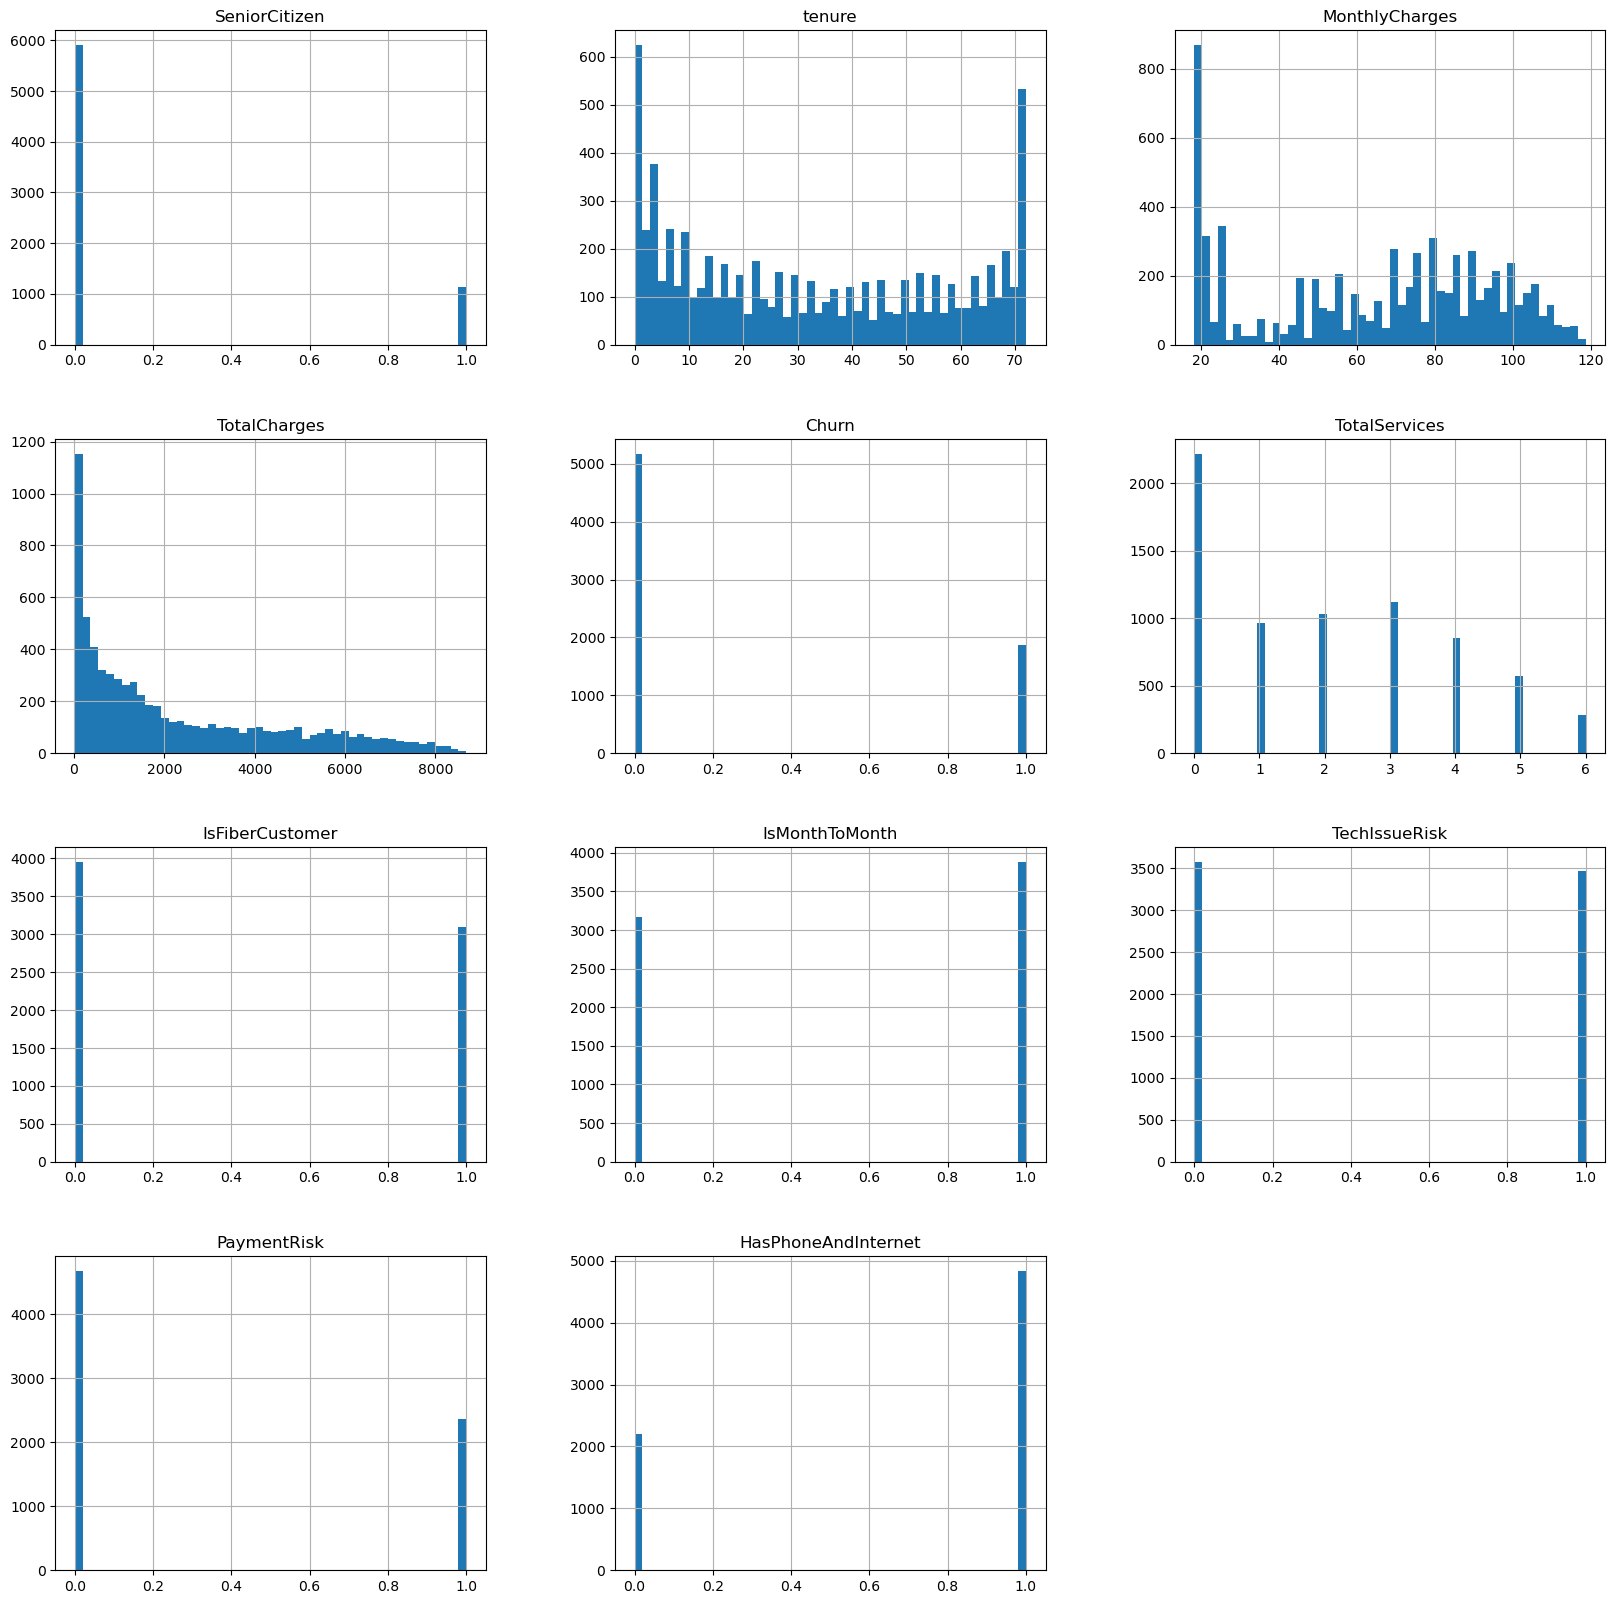

In [18]:
# valid only to tenure, MonthlyCharges, TotalCharges

data.hist(figsize=(20, 20), bins=50)

In [19]:
#value count of each column
for column in data.columns:
    print(data[column].value_counts())
    print("\n")

gender
Male      3555
Female    3488
Name: count, dtype: int64


SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64


Partner
No     3641
Yes    3402
Name: count, dtype: int64


Dependents
No     4933
Yes    2110
Name: count, dtype: int64


tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64


PhoneService
Yes    6361
No      682
Name: count, dtype: int64


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


DeviceProtection
No                     3095
Yes       

In [25]:
x_cat = data.drop(columns=['Churn'])
y = data['Churn']

x_train, x_test, y_train, y_test = train_test_split(
    x_cat, y, test_size=0.2, random_state=42, stratify=y
)

In [32]:
x_cat = data[all_features].copy()
y = data[target_col].copy()

x_train, x_test, y_train, y_test = train_test_split(
    x_cat, y, test_size=0.2, random_state=42, stratify=y
)

In [33]:
train_pool = Pool(data=x_train, label=y_train, cat_features=cat_cols)

test_pool = Pool(data=x_test, label=y_test, cat_features=cat_cols)

In [35]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose = 100,
    task_type='GPU',
)

model.fit(
    train_pool, 
    eval_set=test_pool,
    use_best_model=True,    
)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8225490	best: 0.8225490 (0)	total: 3.87s	remaining: 1h 4m 26s
100:	test: 0.8455165	best: 0.8455165 (100)	total: 8.59s	remaining: 1m 16s
200:	test: 0.8455411	best: 0.8456742 (165)	total: 12.7s	remaining: 50.5s
300:	test: 0.8454920	best: 0.8456742 (165)	total: 15.9s	remaining: 36.9s
400:	test: 0.8452543	best: 0.8456742 (165)	total: 19.6s	remaining: 29.2s
500:	test: 0.8448513	best: 0.8456742 (165)	total: 22.6s	remaining: 22.5s
600:	test: 0.8446356	best: 0.8456742 (165)	total: 26.1s	remaining: 17.3s
700:	test: 0.8447596	best: 0.8456742 (165)	total: 29.8s	remaining: 12.7s
800:	test: 0.8443359	best: 0.8456742 (165)	total: 32.9s	remaining: 8.17s
900:	test: 0.8444871	best: 0.8456742 (165)	total: 36.3s	remaining: 3.99s
999:	test: 0.8444147	best: 0.8456742 (165)	total: 39.6s	remaining: 0us
bestTest = 0.8456741571
bestIteration = 165
Shrink model to first 166 iterations.


In [36]:
y_proba = model.predict_proba(test_pool)[:, 1]
y_pred = model.predict(test_pool)

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred))

ROC-AUC: 0.8456741326306544

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [38]:
importances = model.get_feature_importance(train_pool, type="PredictionValuesChange")
feat_importance = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_importance)

                feature  importance
0                tenure   20.314173
6        IsMonthToMonth   15.622268
1        MonthlyCharges   11.147983
5       IsFiberCustomer    8.554318
2          TotalCharges    8.462353
22             Contract    7.798744
7         TechIssueRisk    4.276567
16       OnlineSecurity    3.634334
23     PaperlessBilling    3.131451
8           PaymentRisk    3.070507
14        MultipleLines    2.594945
21      StreamingMovies    1.828531
15      InternetService    1.691714
17         OnlineBackup    1.282886
19          TechSupport    1.037926
20          StreamingTV    0.976871
4         TotalServices    0.876700
12           Dependents    0.713875
10               gender    0.635758
25          TenureGroup    0.522352
3         SeniorCitizen    0.519303
13         PhoneService    0.469290
18     DeviceProtection    0.465982
24        PaymentMethod    0.313840
9   HasPhoneAndInternet    0.057329
11              Partner    0.000000


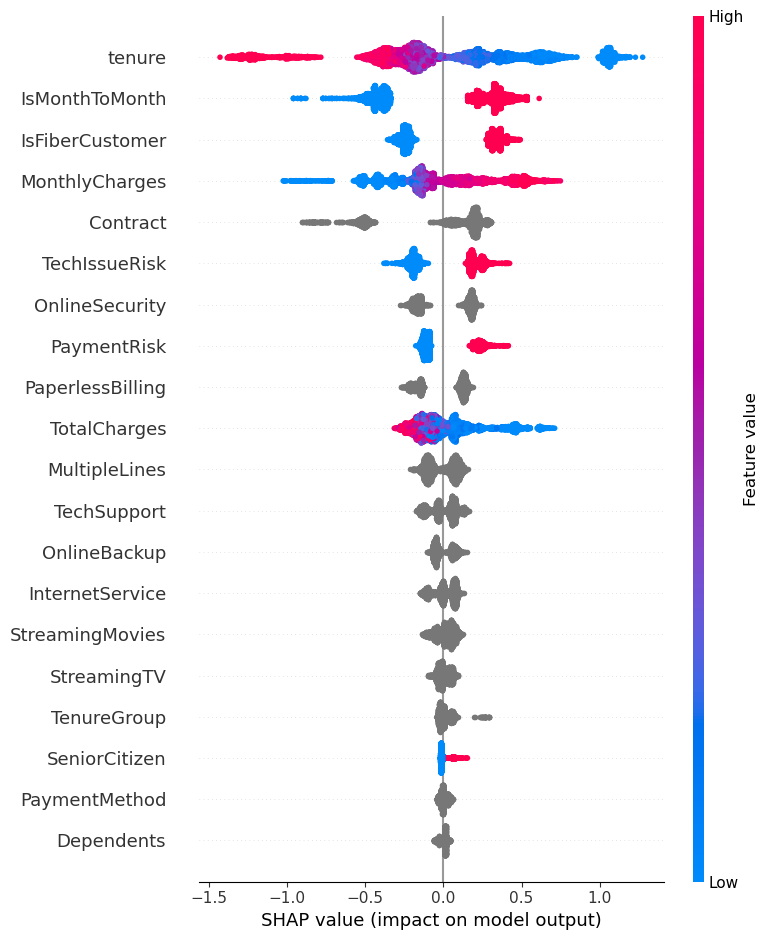

In [42]:
shap_values = model.get_feature_importance(
    train_pool,
    type="ShapValues"
)

# shap_values shape: (n_samples, n_features + 1)
# last column is expected value (base value)
shap_values_features = shap_values[:, :-1]

# If you want a summary plot (needs shap library)
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap.summary_plot(shap_values_features, x_train, feature_names=all_features)
